In [16]:
from cgr.filepaths import filepaths
from cgr.draw import draw_molecule, draw_reaction
from cgr.cheminfo import MorganFingerprinter, tanimoto_similarity
import json
from IPython.display import SVG
from rdkit import Chem
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import entropy
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering

In [17]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

def show_rxn(sma: str):
    display(SVG(draw_reaction(sma)))

organic_elements = {
    0: '*',
    1: 'H',    # Hydrogen
    6: 'C',    # Carbon
    7: 'N',    # Nitrogen
    8: 'O',    # Oxygen
    9: 'F',    # Fluorine
    16: 'S',   # Sulfur
    17: 'Cl',  # Chlorine
    35: 'Br',  # Bromine
    53: 'I',   # Iodine
    15: 'P',   # Phosphorus
}

def get_subsmiles(molecule: Chem.Mol, aidx: int, radius: int):
    if radius == 0:
        atomic_num = molecule.GetAtomWithIdx(aidx).GetAtomicNum()
        return organic_elements[atomic_num]

    env = Chem.FindAtomEnvironmentOfRadiusN(
        mol=molecule,
        radius=radius,
        rootedAtAtom=aidx
    )

    submol = Chem.PathToSubmol(
        mol=molecule,
        path=env    
    )

    return Chem.MolToSmiles(submol)

In [18]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}
print(len(decarb))

86


Test case for location sensitive ecfp

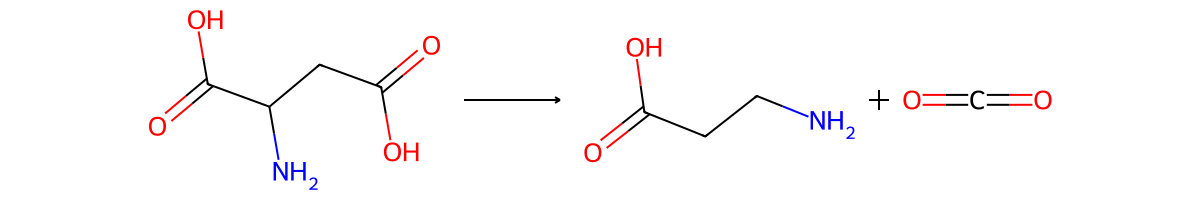

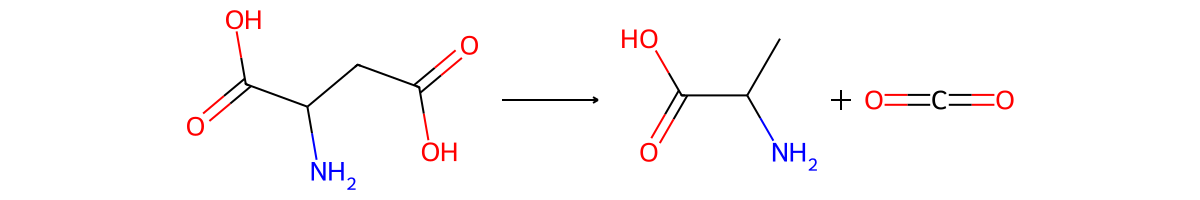

In [19]:
alpha_amino_id = '1162'
beta_amino_id = '17157'

alpha_smarts = decarb[alpha_amino_id]['smarts']
beta_smarts = decarb[beta_amino_id]['smarts']

alpha_smi = alpha_smarts.split('>>')[0]
beta_smi = beta_smarts.split('>>')[0]

alpha_mol = Chem.MolFromSmiles(alpha_smi)
beta_mol = Chem.MolFromSmiles(beta_smi)

show_rxn(alpha_smarts)
show_rxn(beta_smarts)

In [20]:
radius = 3
length = 2**11
mfper = MorganFingerprinter(radius=radius, length=length)

In [21]:
alpha_mfp = mfper.fingerprint(alpha_mol)
beta_mfp = mfper.fingerprint(beta_mol)
tanimoto_similarity(alpha_mfp, beta_mfp)

np.float64(1.0)

In [22]:
alpha_rc = decarb[alpha_amino_id]['reaction_center'][0]
beta_rc = decarb[beta_amino_id]['reaction_center'][0]

alpha_mfp_w_loc = mfper.fingerprint(alpha_mol, reaction_center=alpha_rc)
beta_mfp_w_loc = mfper.fingerprint(beta_mol, reaction_center=beta_rc)
tanimoto_similarity(alpha_mfp_w_loc, beta_mfp_w_loc)

np.float64(0.2857142857142857)

In [23]:
print(f"normal: {float((alpha_mfp.sum() / length) * 100):2f}% density")
print(f"w/ loc: {float((alpha_mfp_w_loc.sum() / length) * 100):2f}% density")

normal: 0.878906% density
w/ loc: 1.074219% density


Demonstrate clustering similarity with ecfp, loc sensitive ecfp, and rooted loc ecfp

In [24]:
radius = 2
length = 2**11
mfper = MorganFingerprinter(radius=radius, length=length)
rc_dist_ub = 1

M = [] # Trad morgan
L = [] # w/ location info
R = [] # w/ loc info and rooted at peri-rc substructure
for key, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)
        M.append(mfper.fingerprint(mol))
        L.append(mfper.fingerprint(mol, reaction_center=rc))
        R.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))

M = np.vstack(M)
L = np.vstack(L)
R = np.vstack(R)

tmp = []
for mat in [M, L, R]:
    c = mat.sum(axis=1) # Cardinality
    S = np.matmul(mat, mat.T) # Straight dot product
    tmp.append(S / (c.reshape(1, -1) + c.reshape(-1, 1) - S)) # Tanimoto similarity
    # tmp.append(S)

Sm, Sl, Sr = tmp

In [25]:
kopts = list(decarb.keys())
sim_mats = {
    'traditional': Sm,
    'location': Sl,
    'location_rooted': Sr
}
stopts = list(sim_mats.keys())

@interact
def rank_by_one(
    query = widgets.Dropdown(value=kopts[0], options=kopts),
    sim_type = widgets.Dropdown(value=stopts[0], options=stopts),
    topk: int = 10
):    

    idx = kopts.index(query)
    sim_row = sim_mats[sim_type][idx, :]
    srt_sim_key = sorted(zip(sim_row, kopts), key=lambda x : x[0], reverse=True)

    for i, (sim, k) in enumerate(srt_sim_key):
        if i == 0:
            print("Query")
        else:
            print(f"Other ID: {k}")
            print(f"Similarity score: {sim}")
        
        rxn = decarb[k]
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        display(SVG(draw_molecule(smiles, highlight_atoms=rc, size=(400, 250))))

        if i == 0:
            print('-' * 50)

        if i > topk:
            break

interactive(children=(Dropdown(description='query', options=('14', '55', '121', '734', '1067', '1162', '1565',…

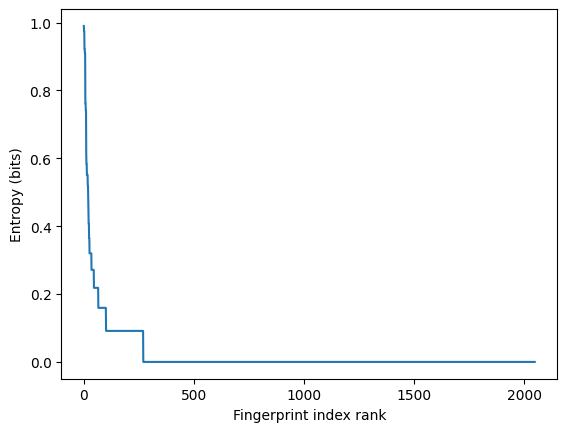

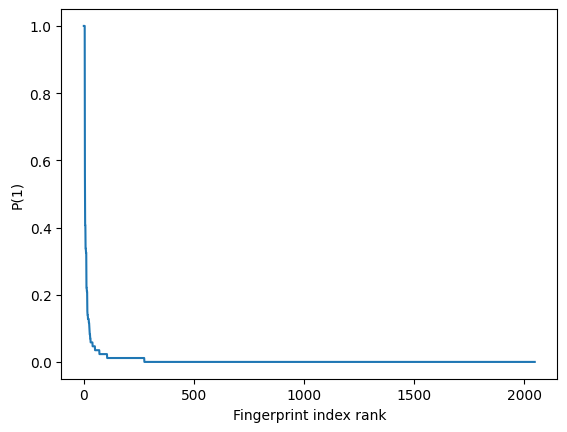

In [26]:
radius = 2
length = 2**11
mfper = MorganFingerprinter(radius=radius, length=length, allocate_ao=True)
rc_dist_ub = 1

embeds = []
bims = [] # BitInfoMaps {bit_idx: ((central atom idx, radius))}
mols = []
for key, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)

        embeds.append(mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub))
        bims.append(mfper.bit_info_map)
        mols.append(mol)

embeds = np.vstack(embeds)

p1 = embeds.sum(axis=0) / embeds.shape[0]
probas = np.vstack((p1, (1 - p1)))
elt_entropy = entropy(pk=probas, axis=0, base=2)
elt_entropy = np.array(elt_entropy)
entropy_idx, srt_entropy = zip(*sorted(zip(np.arange(len(elt_entropy)), elt_entropy), key=lambda x : x[1], reverse=True))
entropy_idx, srt_entropy = np.array(entropy_idx), np.array(srt_entropy)
x = np.arange(len(elt_entropy))

fig, ax = plt.subplots()
ax.plot(x, srt_entropy)
ax.set_ylabel("Entropy (bits)")
ax.set_xlabel("Fingerprint index rank")
plt.show()


p1_idx, srt_p1 = zip(*sorted(zip(np.arange(len(p1)), p1), key=lambda x : x[1], reverse=True))
p1_idx, srt_p1 = np.array(p1_idx), np.array(srt_p1)

fig, ax = plt.subplots()
ax.plot(x, srt_p1)
ax.set_ylabel("P(1)")
ax.set_xlabel("Fingerprint index rank")
plt.show()

In [27]:
fpidx_2_unique_smiles = defaultdict(set)

for idx in entropy_idx:
    for bim, mol in zip(bims, mols):
        roots = bim.get(idx, tuple())
        for aidx, radius in roots:
            subsmiles = get_subsmiles(mol, aidx, radius)
            fpidx_2_unique_smiles[idx].add(subsmiles)

n_collisions = 0
for k, v in fpidx_2_unique_smiles.items():
    if len(v) > 1:
        n_collisions += 1


print(f"Collision rate: {n_collisions / len(fpidx_2_unique_smiles)}")

Collision rate: 0.09090909090909091


In [28]:
sparsities = embeds.sum(axis=1)
print(f"Sparsity: {sparsities.mean():.2f} +/- {sparsities.std():.2f}")

Sparsity: 14.74 +/- 1.17


Entropy = 0.0 bits
Probability: 1.00
{'CC(O)C(=O)C(C)O', 'C'}


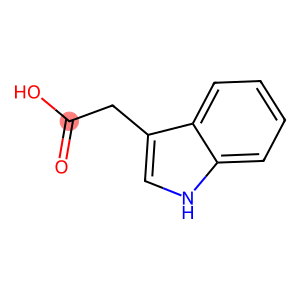

--------------------------------------------------
Entropy = 0.0 bits
Probability: 1.00
{'C=O'}


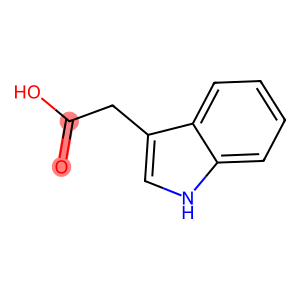

--------------------------------------------------
Entropy = 0.0 bits
Probability: 1.00
{'O'}


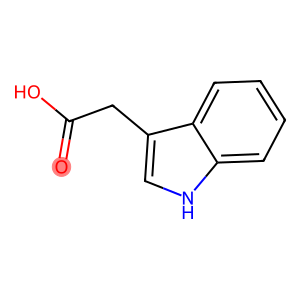

--------------------------------------------------
Entropy = 0.0 bits
Probability: 1.00
{'CO'}


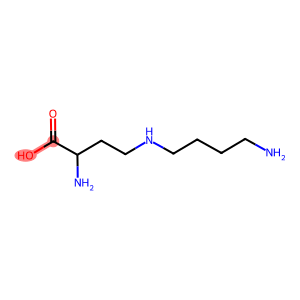

--------------------------------------------------
Entropy = 0.0 bits
Probability: 1.00
{'O', 'CC(N)CS(=O)(=O)O'}


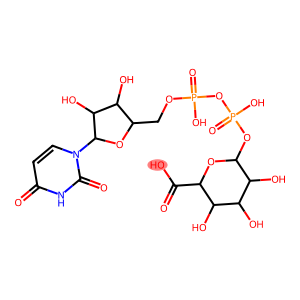

--------------------------------------------------
Entropy = 0.9902246902198684 bits
Probability: 0.56
{'C'}


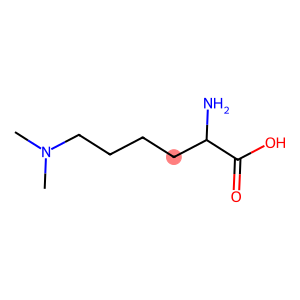

--------------------------------------------------
Entropy = 0.9748857077995388 bits
Probability: 0.41
{'C'}


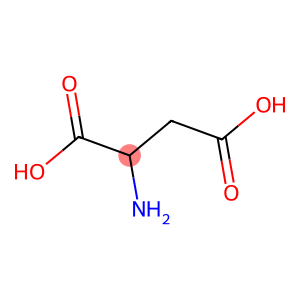

--------------------------------------------------
Entropy = 0.9748857077995388 bits
Probability: 0.41
{'CC(=O)O'}


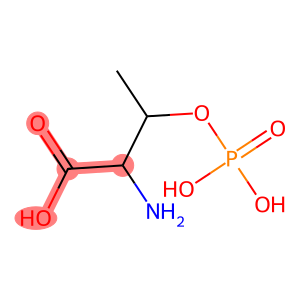

--------------------------------------------------
Entropy = 0.9221231306777972 bits
Probability: 0.34
{'N'}


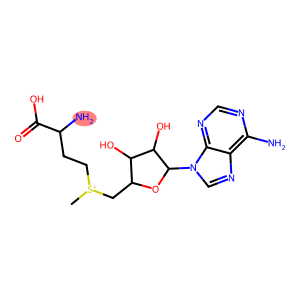

--------------------------------------------------
Entropy = 0.9221231306777972 bits
Probability: 0.34
{'CN'}


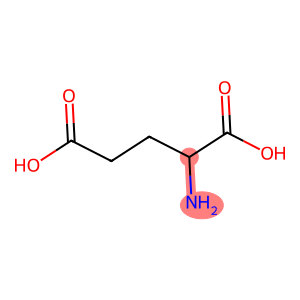

--------------------------------------------------
Entropy = 0.9103480624345155 bits
Probability: 0.33
{'CC(N)C(=O)O'}


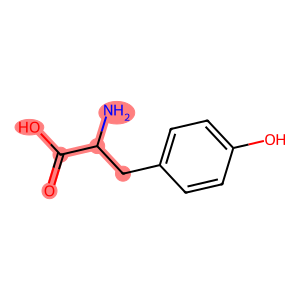

--------------------------------------------------
Entropy = 0.9103480624345155 bits
Probability: 0.33
{'CC(C)N'}


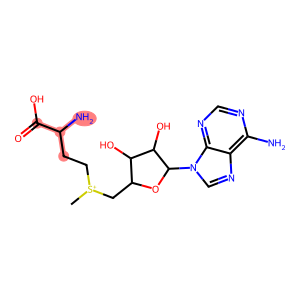

--------------------------------------------------
Entropy = 0.7618624463753669 bits
Probability: 0.22
{'C'}


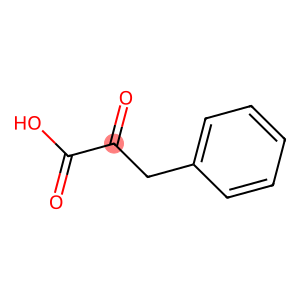

--------------------------------------------------
Entropy = 0.7618624463753669 bits
Probability: 0.22
{'CC(=O)O'}


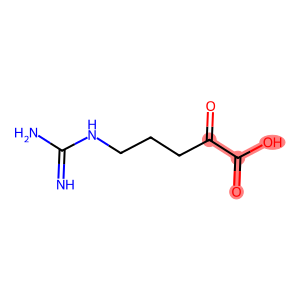

--------------------------------------------------
Entropy = 0.7401470427139037 bits
Probability: 0.21
{'O'}


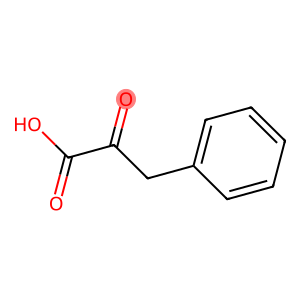

--------------------------------------------------
Entropy = 0.7401470427139037 bits
Probability: 0.21
{'C=O'}


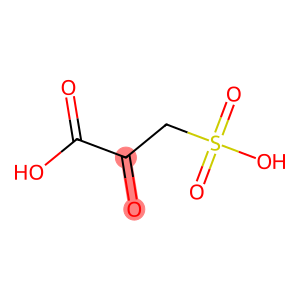

--------------------------------------------------
Entropy = 0.6127425554686624 bits
Probability: 0.15
{'C'}


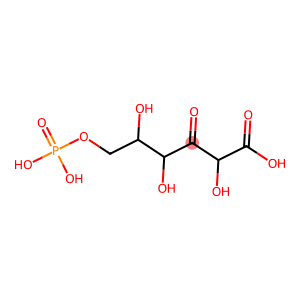

--------------------------------------------------
Entropy = 0.5830194167347008 bits
Probability: 0.14
{'CC(=O)O'}


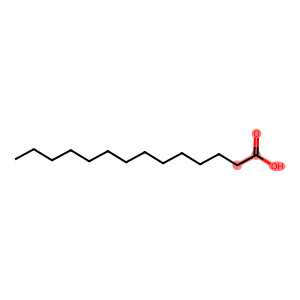

--------------------------------------------------
Entropy = 0.5830194167347008 bits
Probability: 0.14
{'C'}


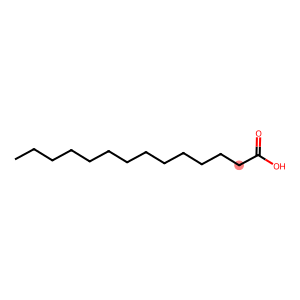

--------------------------------------------------
Entropy = 0.5516699920020824 bits
Probability: 0.13
{'CC(C)=O'}


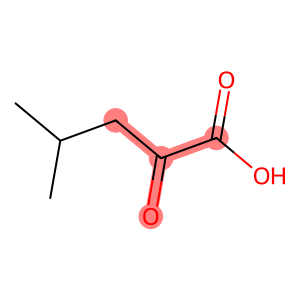

--------------------------------------------------
Entropy = 0.5516699920020824 bits
Probability: 0.13
{'CCC(N)C(=O)O'}


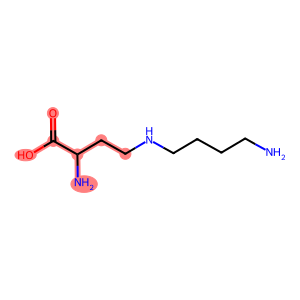

--------------------------------------------------
Entropy = 0.5516699920020824 bits
Probability: 0.13
{'CCC'}


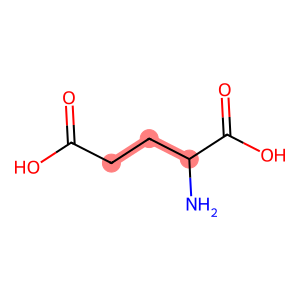

--------------------------------------------------
Entropy = 0.5516699920020824 bits
Probability: 0.13
{'CC(=O)C(=O)O'}


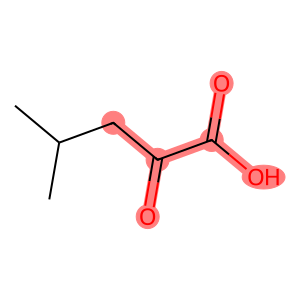

--------------------------------------------------
Entropy = 0.5185697317883058 bits
Probability: 0.12
{'cC(=O)O'}


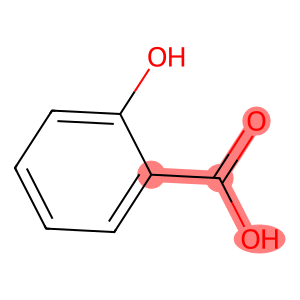

--------------------------------------------------
Entropy = 0.5185697317883058 bits
Probability: 0.12
{'C'}


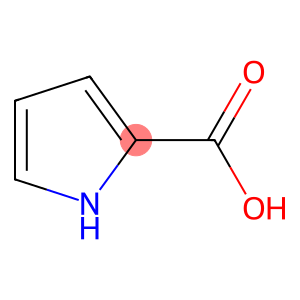

--------------------------------------------------
Entropy = 0.48356837509176975 bits
Probability: 0.10
{'C'}


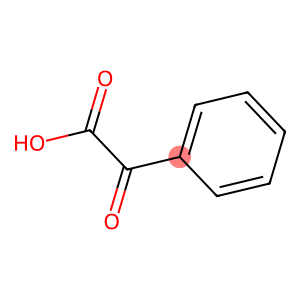

--------------------------------------------------
Entropy = 0.44648134689680286 bits
Probability: 0.09
{'CC(O)C(=O)O', 'cCC(N)C(=O)O'}


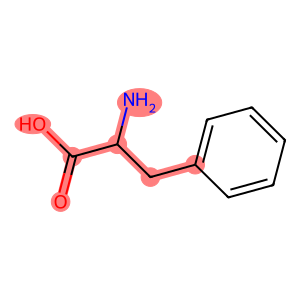

--------------------------------------------------
Entropy = 0.40707680632541937 bits
Probability: 0.08
{'O'}


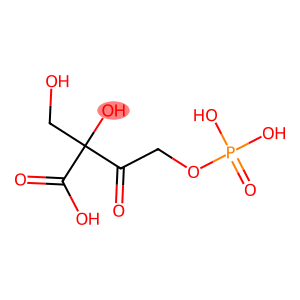

--------------------------------------------------
Entropy = 0.40707680632541937 bits
Probability: 0.08
{'cCC', 'CCc'}


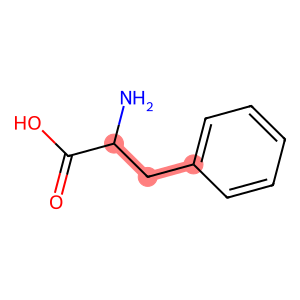

--------------------------------------------------
Entropy = 0.3650551896402849 bits
Probability: 0.07
{'C'}


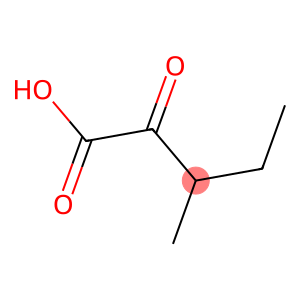

--------------------------------------------------
Entropy = 0.3650551896402849 bits
Probability: 0.07
{'C'}


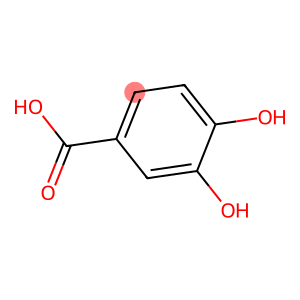

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCC'}


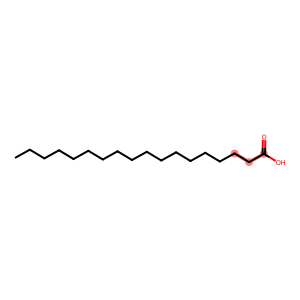

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'C'}


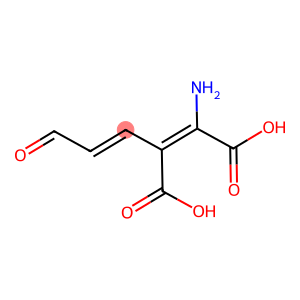

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCC(=O)O'}


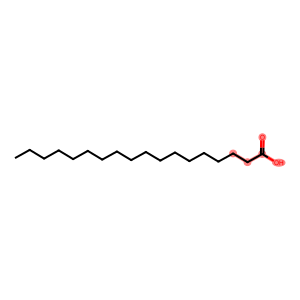

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCC'}


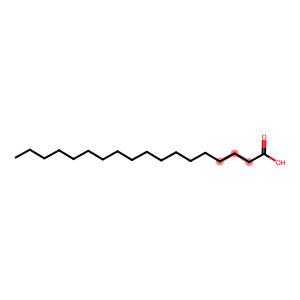

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'C'}


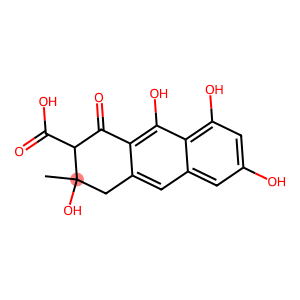

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCCC(=O)O'}


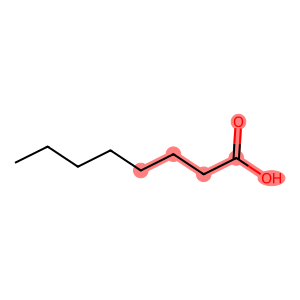

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCC(=O)C(=O)O', 'ccc(C(=O)O)c(c)C'}


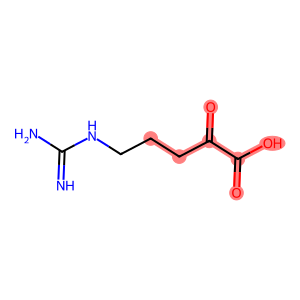

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCCCC'}


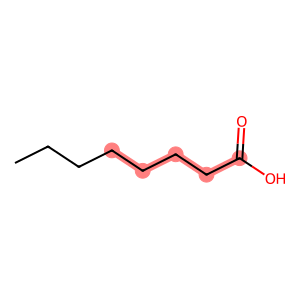

--------------------------------------------------
Entropy = 0.3200148627475466 bits
Probability: 0.06
{'CCCC(C)N'}


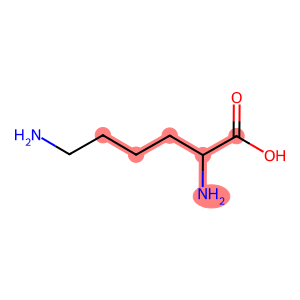

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'CCO'}


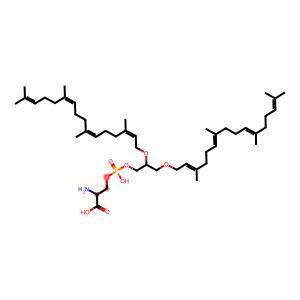

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'CC(=O)O'}


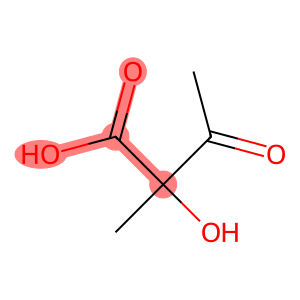

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'C'}


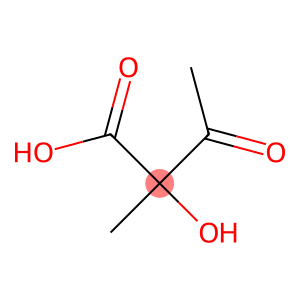

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'CCC(=O)C(=O)O', 'C=CC'}


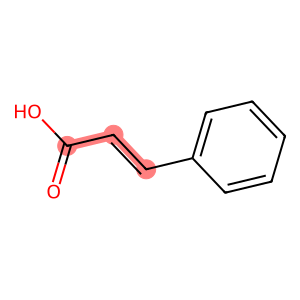

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'CC(O)C(O)C(=O)O', 'C=CC(=O)O'}


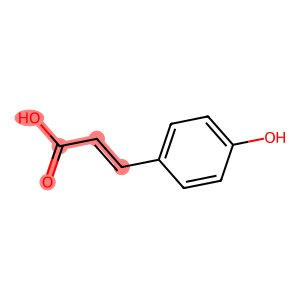

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'cc(c)C(=O)O', 'C=C(C)C=CC'}


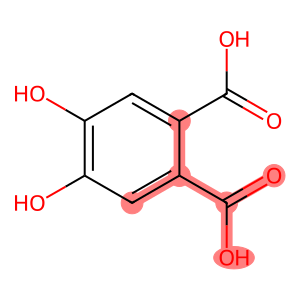

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'C'}


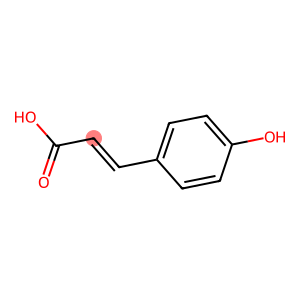

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'NC(CO)C(=O)O'}


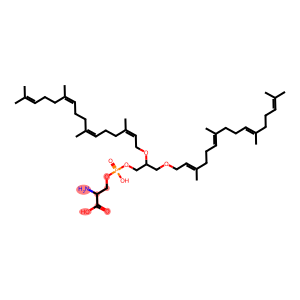

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'ccc'}


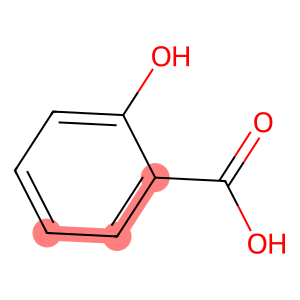

--------------------------------------------------
Entropy = 0.2713895875081111 bits
Probability: 0.05
{'CCC'}


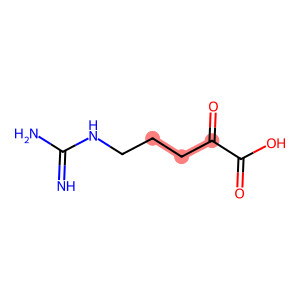

--------------------------------------------------


In [29]:
rng = np.random.default_rng(seed=1234) # TODO seed=1234, resampling same integer for first hash / substruct
n_egs = 1
topk = 50
srt_idx = p1_idx

mols_w_fpids = defaultdict(list)
egs = [0 for i in range(len(srt_idx))]
for idx in srt_idx:
    for bim, mol in zip(bims, mols):
        if idx in bim:
            mols_w_fpids[idx].append((bim[idx], mol))

for idx in srt_idx[:topk]:
    egs = rng.integers(low=0, high=len(mols_w_fpids[idx]) - 1, size=(n_egs, ))
    print(f"Entropy = {elt_entropy[idx]} bits")
    print(f"Probability: {p1[idx]:.2f}")
    print(fpidx_2_unique_smiles[idx])
    for eg in egs:
        sub_atom_idxs = set()
        roots, mol = mols_w_fpids[idx][eg]
        aidx, r = roots[0]

        if r == 0:
            sub_atom_idxs.add(aidx)
        else:
            env = Chem.FindAtomEnvironmentOfRadiusN(
                mol=mol,
                radius=r,
                rootedAtAtom=aidx
            )
            for bidx in env:
                bond = mol.GetBondWithIdx(bidx)
                sub_atom_idxs.add(bond.GetBeginAtomIdx())
                sub_atom_idxs.add(bond.GetEndAtomIdx())

        display(SVG(draw_molecule(mol, size=(300, 300), highlight_atoms=tuple(sub_atom_idxs))))
    print('-' * 50)
    

In [30]:
srt_embeds = embeds[:, entropy_idx]
embeds_w_info = srt_embeds[:, np.where(srt_entropy > 0)[0]]
embeds_w_info.shape

(86, 270)

In [31]:
mim = mutual_info_matrix(pd.DataFrame(embeds_w_info[:, :5]), nbins=2, normalized=True)
mim

,0,1,2,3,4
0,1.000000,0.197406,0.197406,0.311287,0.311287
1,0.197406,1.000000,1.000000,0.688586,0.688586
2,0.197406,1.000000,1.000000,0.688586,0.688586
3,0.311287,0.688586,0.688586,1.000000,1.000000
4,0.311287,0.688586,0.688586,1.000000,1.000000


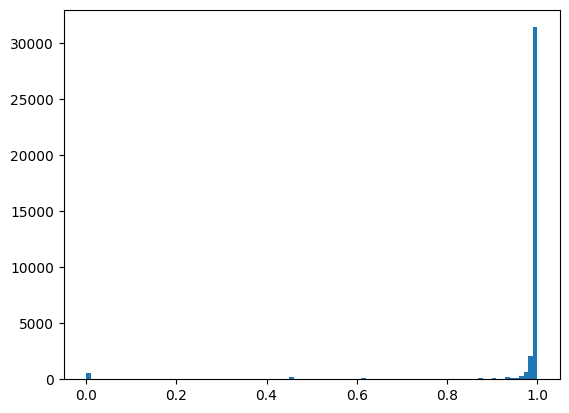

In [32]:
mim = mutual_info_matrix(pd.DataFrame(embeds_w_info), nbins=2, normalized=True)
mim = mim.to_numpy()
mim_hist = mim[np.triu_indices_from(mim)]
plt.hist(1- mim_hist, bins=100)
plt.show()

In [33]:
d_cutoff = 0.5
ac = AgglomerativeClustering(
    n_clusters=None,
    metric='precomputed',
    distance_threshold=d_cutoff,
    linkage='single'
)
ac.fit(1- mim)            
labels = ac.labels_

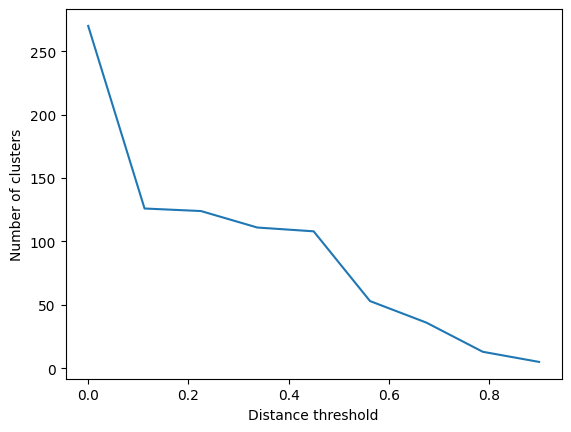

In [34]:
n_clusters = []
for d_cutoff in np.linspace(0.0, 0.9, 9):

    ac = AgglomerativeClustering(
        n_clusters=None,
        metric='precomputed',
        distance_threshold=d_cutoff,
        linkage='single'
    )
    ac.fit(1- mim)            
    labels = ac.labels_
    n_clusters.append(len(set(labels)))

plt.plot(np.linspace(0.0, 0.9, 9), n_clusters)
plt.xlabel("Distance threshold")
plt.ylabel("Number of clusters")
plt.show()

ID: 734
Sequence probability: 0.11334712969288575


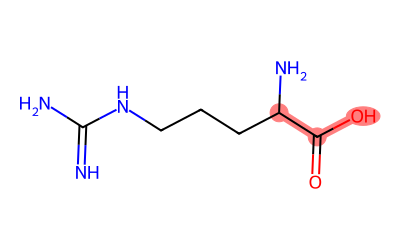

ID: 4324
Sequence probability: 0.11334712969288575


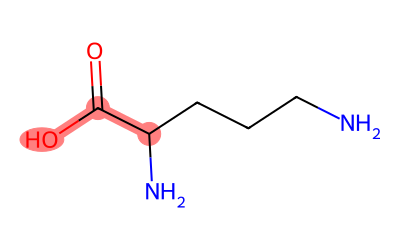

ID: 5043
Sequence probability: 0.11334712969288575


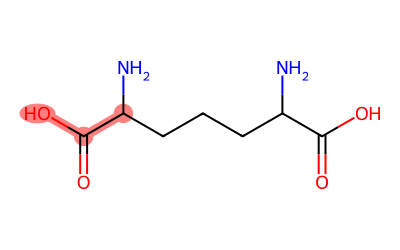

ID: 12619
Sequence probability: 0.11334712969288575


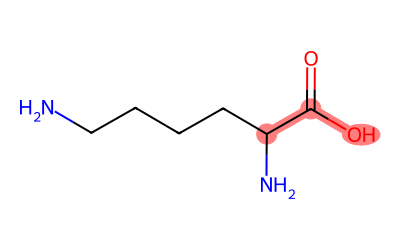

ID: 17802
Sequence probability: 0.11334712969288575


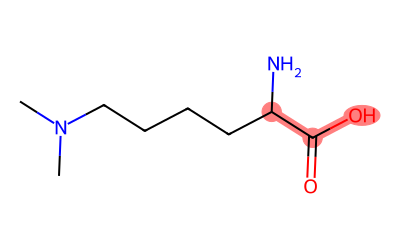

ID: 6882
Sequence probability: 0.043719607167255946


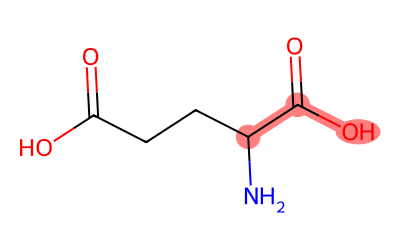

ID: 7099
Sequence probability: 0.043719607167255946


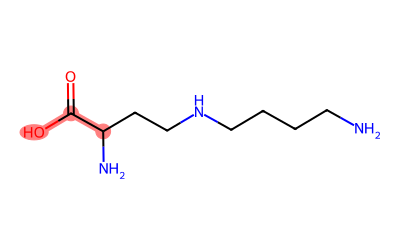

ID: 11336
Sequence probability: 0.043719607167255946


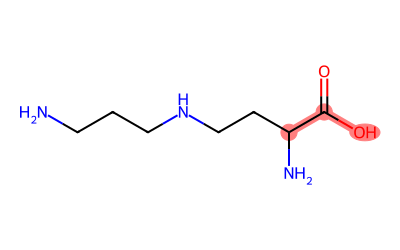

ID: 17153
Sequence probability: 0.043719607167255946


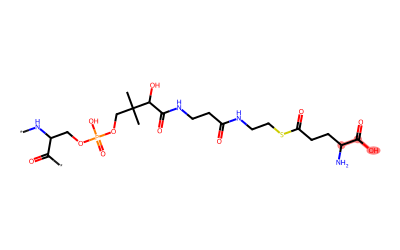

ID: 7342
Sequence probability: 0.02803962449407158


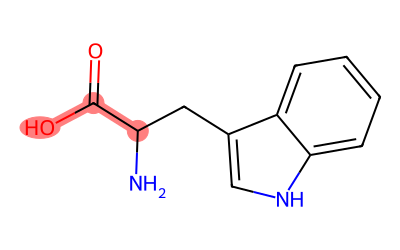

ID: 7914
Sequence probability: 0.02803962449407158


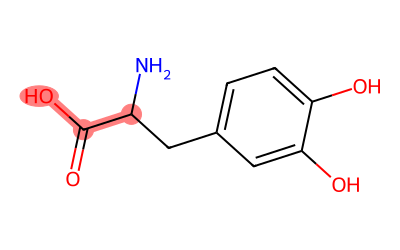

ID: 8894
Sequence probability: 0.02803962449407158


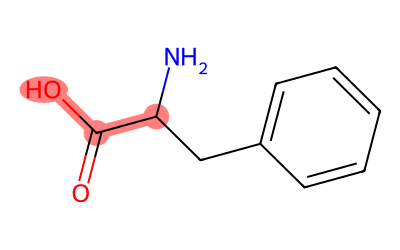

ID: 9371
Sequence probability: 0.02803962449407158


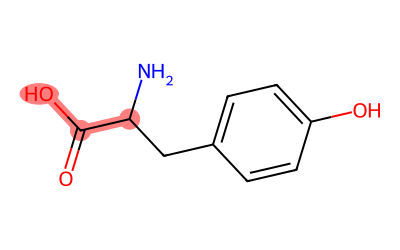

ID: 10634
Sequence probability: 0.02803962449407158


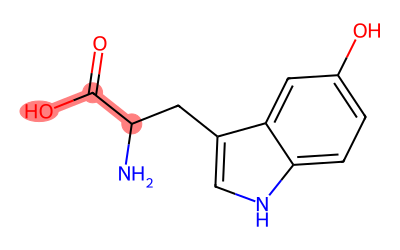

ID: 12520
Sequence probability: 0.02803962449407158


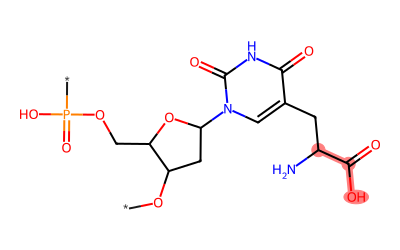

ID: 1814
Sequence probability: 0.021602629423820578


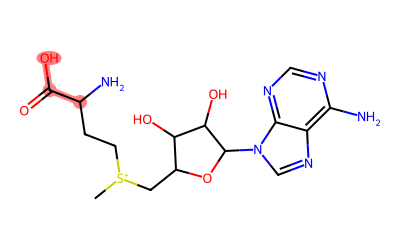

ID: 16650
Sequence probability: 0.02160262942382056


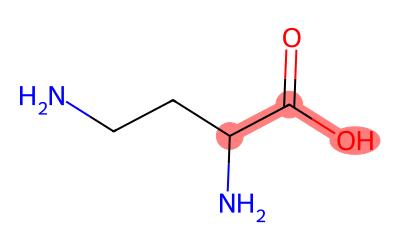

ID: 12307
Sequence probability: 0.011814758435487663


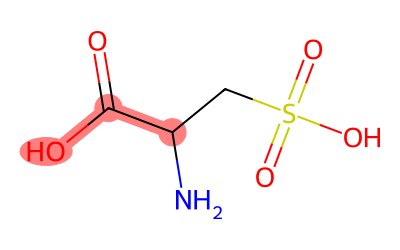

ID: 7561
Sequence probability: 0.009126622874540948


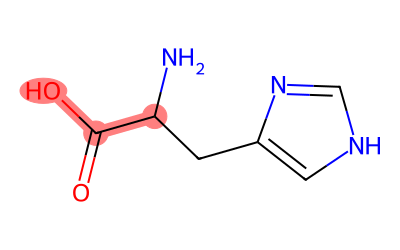

ID: 14
Sequence probability: 0.007341725424172207


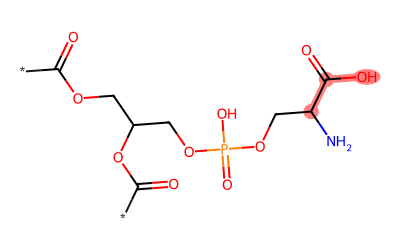

ID: 3306
Sequence probability: 0.007341725424172207


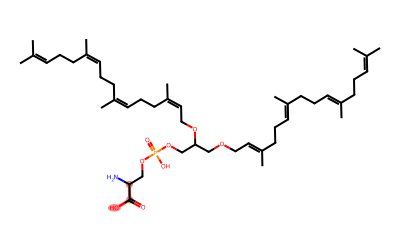

ID: 11349
Sequence probability: 0.007341725424172207


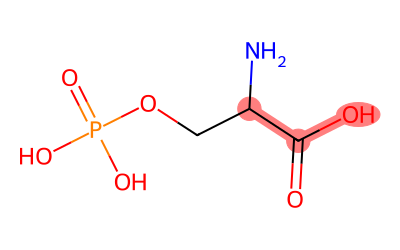

ID: 15761
Sequence probability: 0.002389659647867818


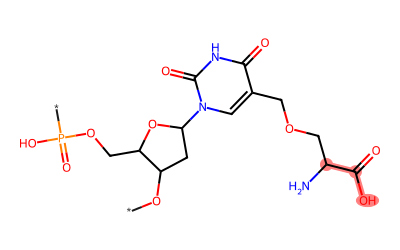

ID: 19445
Sequence probability: 0.00042703946152365045


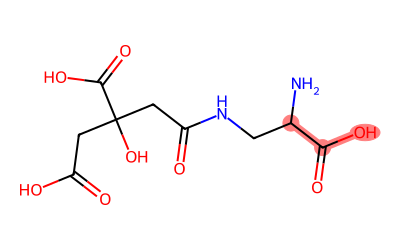

ID: 18393
Sequence probability: 0.0002813037722735158


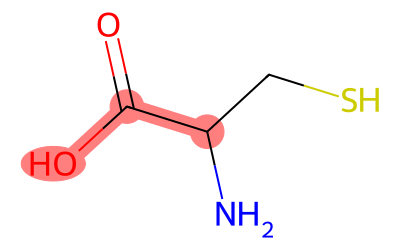

ID: 12995
Sequence probability: 0.00013899715806456076


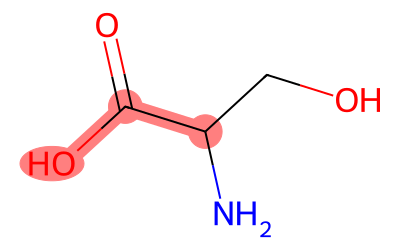

ID: 1162
Sequence probability: 0.00013899715806456073


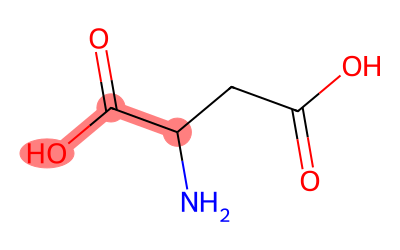

ID: 7754
Sequence probability: 0.00013899715806456073


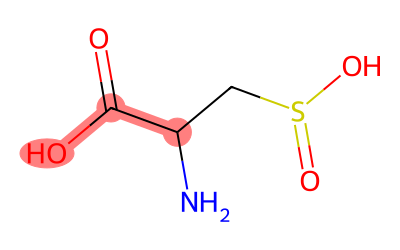

ID: 9599
Sequence probability: 7.080836742591194e-05


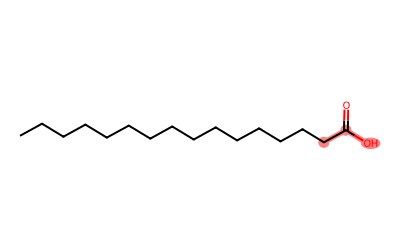

ID: 16361
Sequence probability: 7.080836742591194e-05


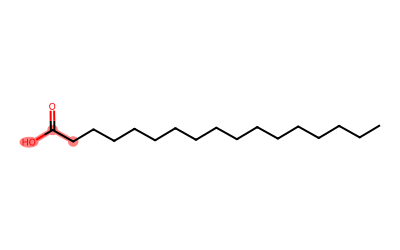

ID: 17237
Sequence probability: 7.080836742591194e-05


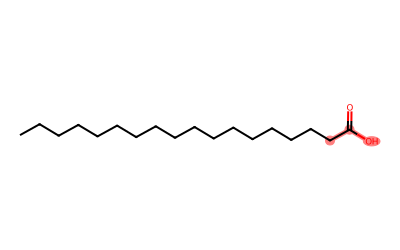

ID: 17305
Sequence probability: 7.080836742591194e-05


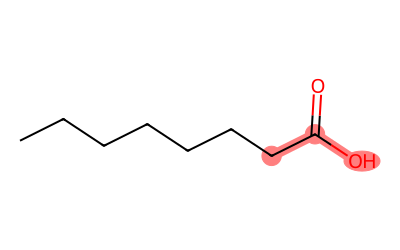

ID: 18112
Sequence probability: 7.080836742591194e-05


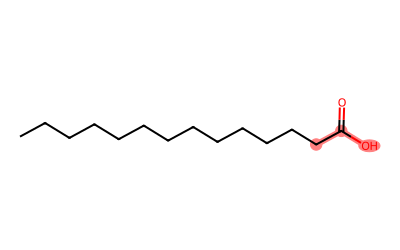

ID: 12879
Sequence probability: 1.7196406917511543e-05


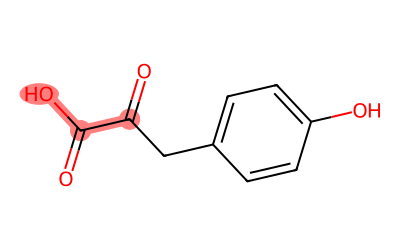

ID: 14999
Sequence probability: 1.7196406917511543e-05


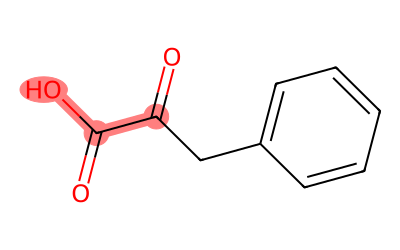

ID: 10234
Sequence probability: 1.2900912358921702e-05


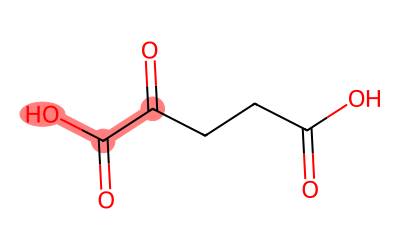

ID: 20241
Sequence probability: 1.2900912358921699e-05


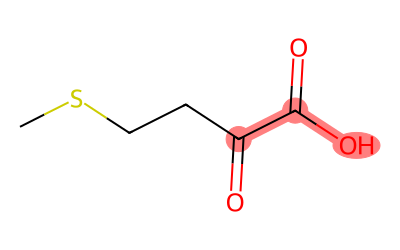

ID: 5645
Sequence probability: 1.2900912358921694e-05


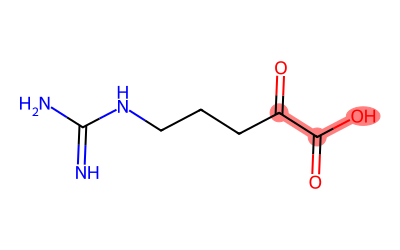

ID: 10213
Sequence probability: 1.2900912358921694e-05


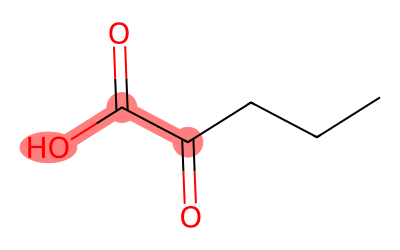

ID: 16170
Sequence probability: 7.92029183549207e-06


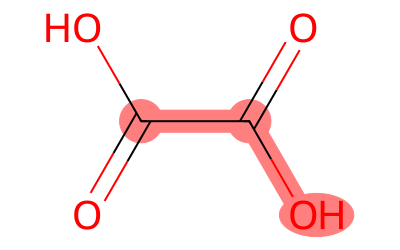

ID: 5026
Sequence probability: 5.59726185942532e-06


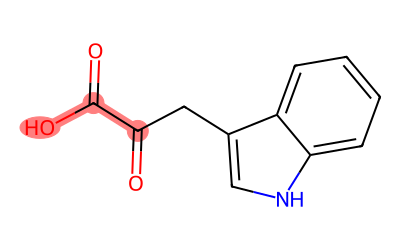

ID: 14059
Sequence probability: 2.4587621201709625e-06


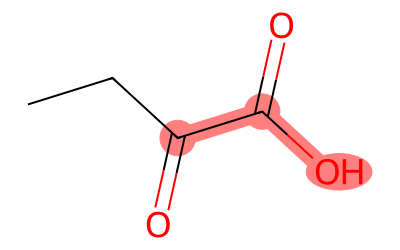

ID: 5401
Sequence probability: 1.3471499838607057e-06


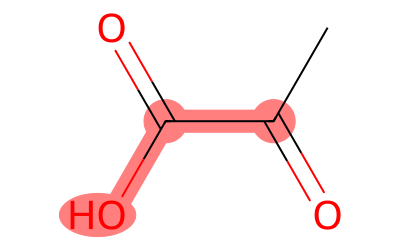

ID: 7059
Sequence probability: 1.200110082464397e-06


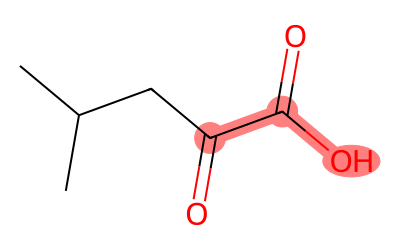

ID: 16979
Sequence probability: 1.200110082464396e-06


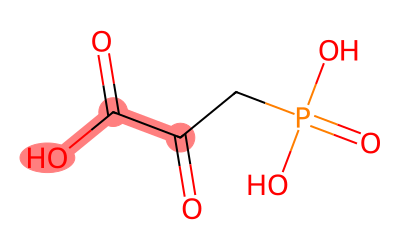

ID: 9307
Sequence probability: 5.929955701588784e-07


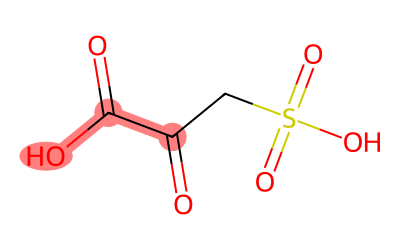

ID: 4489
Sequence probability: 5.196149937748434e-07


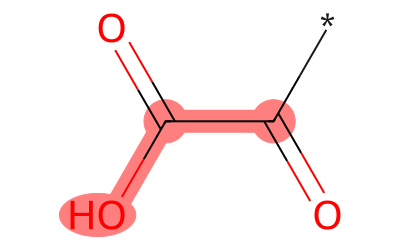

ID: 14788
Sequence probability: 7.396245122087544e-08


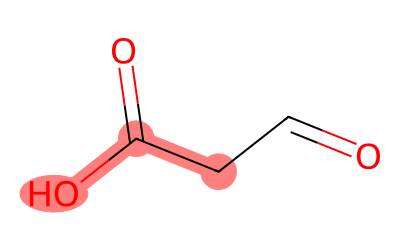

ID: 2688
Sequence probability: 6.3663253771713e-08


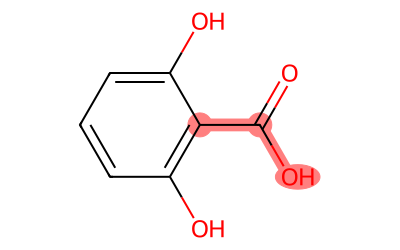

ID: 17157
Sequence probability: 5.448905517272442e-08


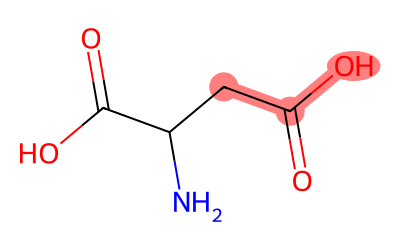

ID: 7354
Sequence probability: 5.012990344987893e-08


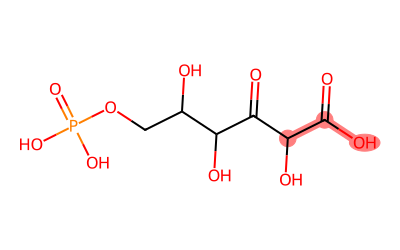

ID: 3024
Sequence probability: 4.7953652114327765e-08


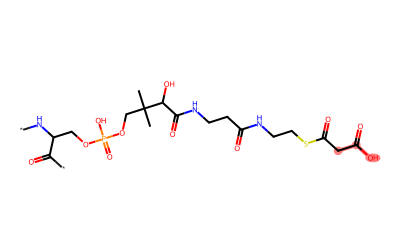

ID: 5735
Sequence probability: 3.925563337163911e-08


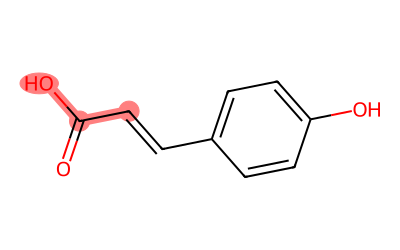

ID: 6894
Sequence probability: 3.925563337163911e-08


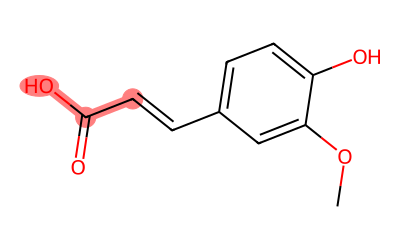

ID: 7383
Sequence probability: 3.925563337163911e-08


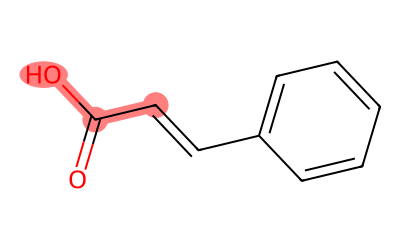

ID: 1565
Sequence probability: 2.3694745750609006e-08


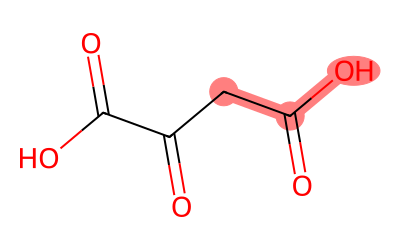

ID: 4992
Sequence probability: 2.3694745750609006e-08


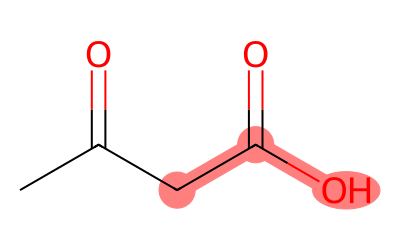

ID: 5000
Sequence probability: 2.0074784276025178e-08


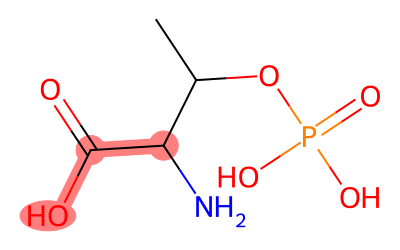

ID: 15374
Sequence probability: 4.330199631426245e-09


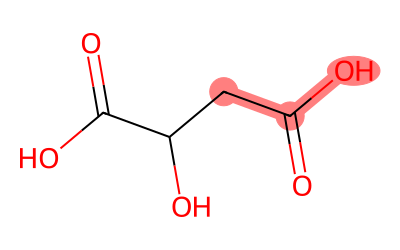

ID: 19342
Sequence probability: 3.3344852776758315e-09


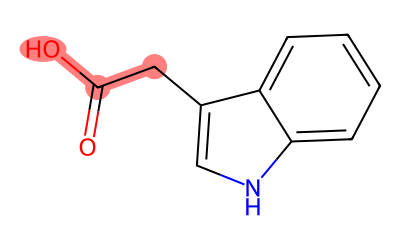

ID: 9452
Sequence probability: 2.13834882762619e-09


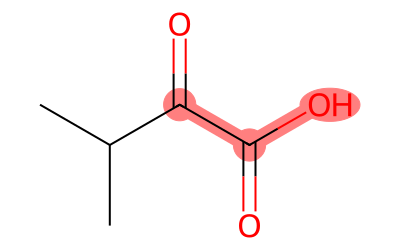

ID: 10268
Sequence probability: 2.138348827626187e-09


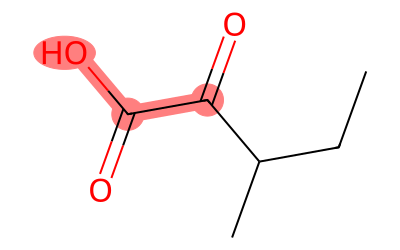

ID: 2771
Sequence probability: 1.1935691297590207e-09


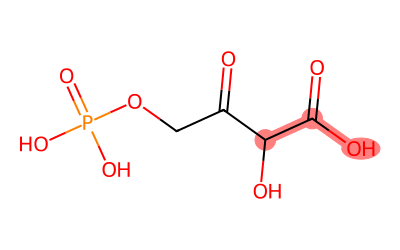

ID: 10184
Sequence probability: 1.0298732509871938e-09


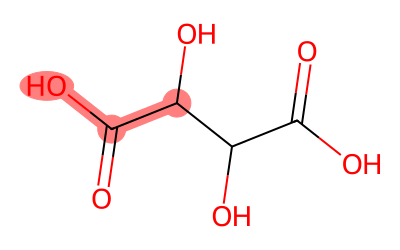

ID: 15539
Sequence probability: 3.5305705773943455e-10


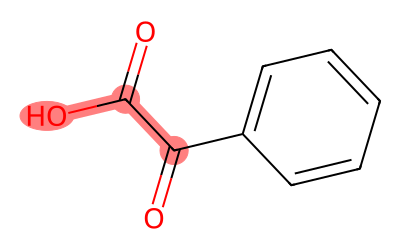

ID: 6613
Sequence probability: 2.2715437310494026e-10


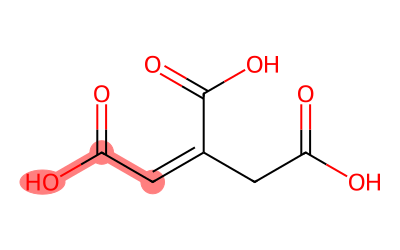

ID: 14478
Sequence probability: 1.4555041842432595e-10


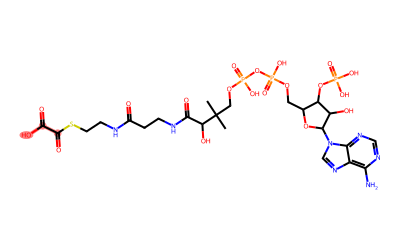

ID: 5140
Sequence probability: 1.3373032224921893e-10


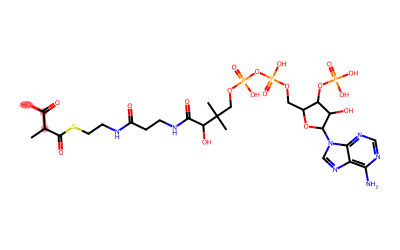

ID: 55
Sequence probability: 3.2194643523527126e-11


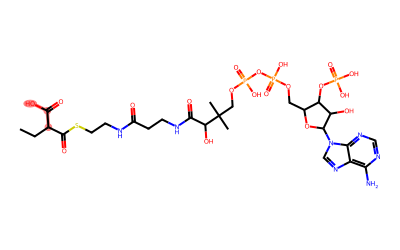

ID: 18573
Sequence probability: 8.811523013385876e-12


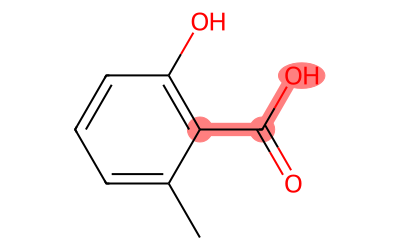

ID: 14700
Sequence probability: 5.8044159532621185e-12


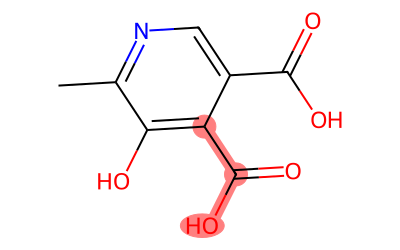

ID: 2556
Sequence probability: 4.930119737078911e-12


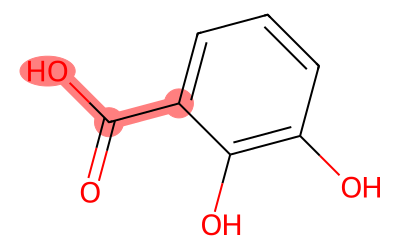

ID: 10549
Sequence probability: 4.679712049039243e-12


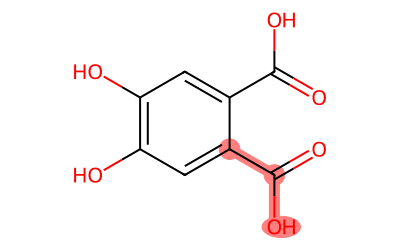

ID: 13477
Sequence probability: 3.698113911923694e-12


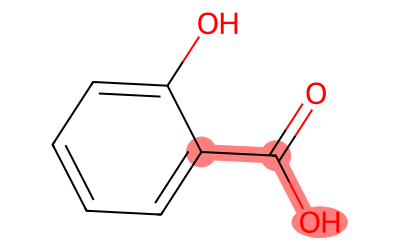

ID: 16353
Sequence probability: 2.4837126398956225e-12


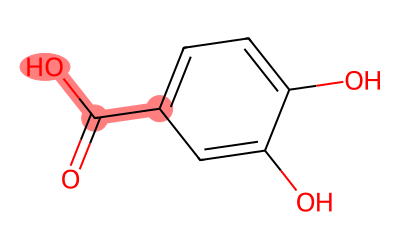

ID: 5907
Sequence probability: 2.126885952233015e-12


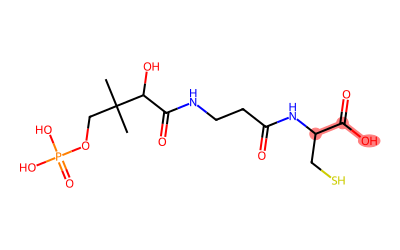

ID: 121
Sequence probability: 5.503871106715724e-13


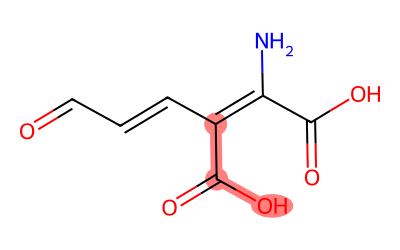

ID: 16925
Sequence probability: 1.7686522452436862e-14


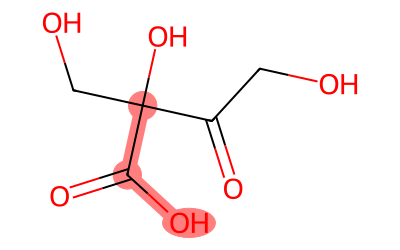

ID: 2589
Sequence probability: 1.0982668573483545e-14


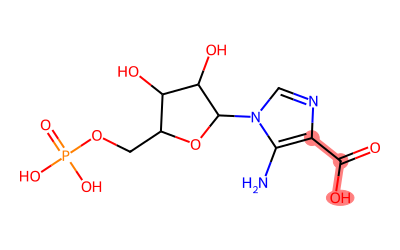

ID: 16821
Sequence probability: 9.51087193131888e-15


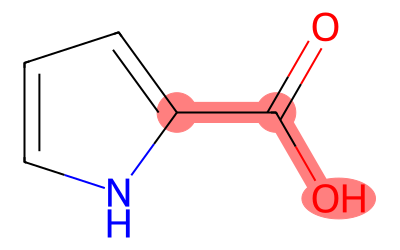

ID: 16625
Sequence probability: 8.739222858851157e-15


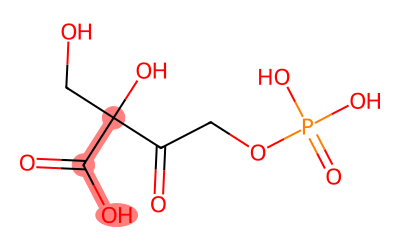

ID: 1067
Sequence probability: 7.047212334651933e-15


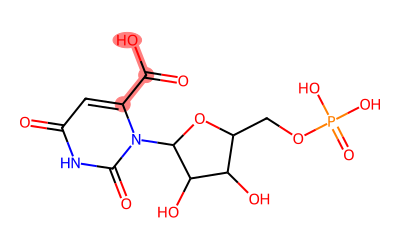

ID: 6221
Sequence probability: 2.1639167248683443e-15


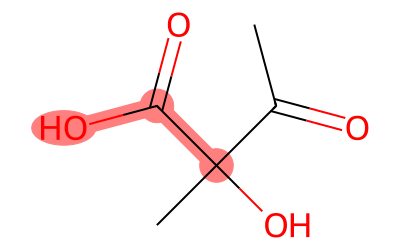

ID: 15876
Sequence probability: 9.351657251581293e-17


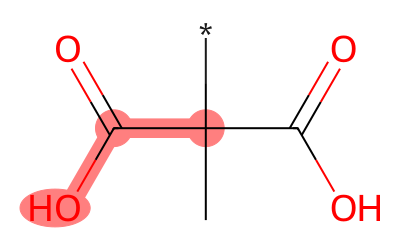

ID: 4235
Sequence probability: 5.075143873460246e-17


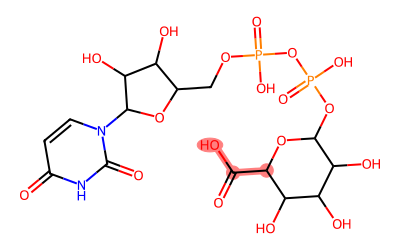

ID: 4590
Sequence probability: 3.0544847386566315e-17


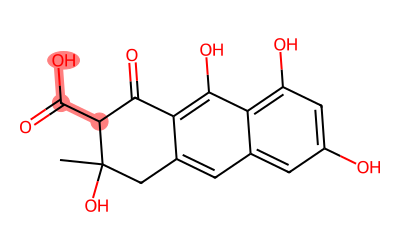

In [35]:
ft_idx = np.arange(embeds.shape[1])
flip_probas = probas[::-1, :]
seq_probs = []
for row in embeds:
    seq_probs.append(np.prod(flip_probas[row, ft_idx]))

seq_probs = np.array(seq_probs) / sum(seq_probs)

srt_kopts, srt_seq_probs = zip(*sorted(zip(kopts, seq_probs), key=lambda x : x[1], reverse=True))

topk = 86
for k, sproba in zip(srt_kopts[:topk], srt_seq_probs[:topk]):
    print(f"ID: {k}")
    print(f"Sequence probability: {sproba}")
    rxn = decarb[k]
    rc = rxn['reaction_center'][0]
    smiles = rxn['smarts'].split('>>')[0]
    display(SVG(draw_molecule(smiles, highlight_atoms=rc, size=(400, 250))))

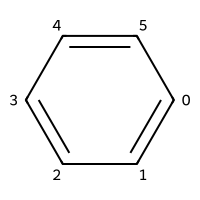

In [36]:
benzene_smiles = 'c1ccccc1'
benzene = Chem.MolFromSmiles(benzene_smiles)
SVG(draw_molecule(benzene, draw_options={'addAtomIndices': True}))

In [44]:
for atom in benzene.GetAtoms():
    print(f"Idx: {atom.GetIdx()}, Valence: {atom.GetTotalValence()}, # Hs: {atom.GetTotalNumHs()}, Degree: {atom.GetDegree()}, Aromatic: {atom.GetIsAromatic()}")

for bond in benzene.GetBonds():
    print(f"{bond.GetBeginAtomIdx()} -> {bond.GetEndAtomIdx()}, Order: {bond.GetBondTypeAsDouble()}")

Idx: 0, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
Idx: 1, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
Idx: 2, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
Idx: 3, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
Idx: 4, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
Idx: 5, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
0 -> 1, Order: 1.5
1 -> 2, Order: 1.5
2 -> 3, Order: 1.5
3 -> 4, Order: 1.5
4 -> 5, Order: 1.5
5 -> 0, Order: 1.5


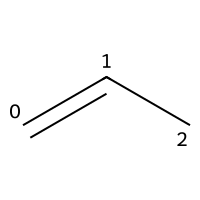

In [38]:
some_smiles = 'C=CC'
some = Chem.MolFromSmiles(some_smiles)
SVG(draw_molecule(some, draw_options={'addAtomIndices': True}))

In [39]:
for atom in some.GetAtoms():
    print(f"Idx: {atom.GetIdx()}, Valence: {atom.GetTotalValence()}, # Hs: {atom.GetTotalNumHs()}, Degree: {atom.GetDegree()}, Aromatic: {atom.GetIsAromatic()}")

Idx: 0, Valence: 4, # Hs: 2, Degree: 1, Aromatic: False
Idx: 1, Valence: 4, # Hs: 1, Degree: 2, Aromatic: False
Idx: 2, Valence: 4, # Hs: 3, Degree: 1, Aromatic: False


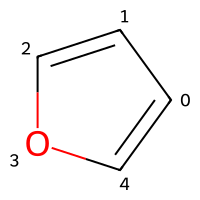

In [40]:
furan_smiles = 'c1ccoc1'
furan = Chem.MolFromSmiles(furan_smiles)
SVG(draw_molecule(furan, draw_options={'addAtomIndices': True}))

In [ ]:
for atom in furan.GetAtoms():
    print(f"Idx: {atom.GetIdx()}, Valence: {atom.GetTotalValence()}, # Hs: {atom.GetTotalNumHs()}, Degree: {atom.GetDegree()}, Aromatic: {atom.GetIsAromatic()}")
    # print(atom.GetNeighbors(), atom.GetBonds())

for bond in furan.GetBonds():
    print(f"{bond.GetBeginAtomIdx()} -> {bond.GetEndAtomIdx()}, Order: {bond.GetBondTypeAsDouble()}")

Idx: 0, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
(<rdkit.Chem.rdchem.Atom object at 0x7ff922b86ab0>, <rdkit.Chem.rdchem.Atom object at 0x7ff922b86a40>) (<rdkit.Chem.rdchem.Bond object at 0x7ff922b869d0>, <rdkit.Chem.rdchem.Bond object at 0x7ff922b86b90>)
Idx: 1, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
(<rdkit.Chem.rdchem.Atom object at 0x7ff91311d540>, <rdkit.Chem.rdchem.Atom object at 0x7ff922b869d0>) (<rdkit.Chem.rdchem.Bond object at 0x7ff922b86b90>, <rdkit.Chem.rdchem.Bond object at 0x7ff922b86ab0>)
Idx: 2, Valence: 4, # Hs: 1, Degree: 2, Aromatic: True
(<rdkit.Chem.rdchem.Atom object at 0x7ff923897d10>, <rdkit.Chem.rdchem.Atom object at 0x7ff922b86b90>) (<rdkit.Chem.rdchem.Bond object at 0x7ff922b86ab0>, <rdkit.Chem.rdchem.Bond object at 0x7ff922b869d0>)
Idx: 3, Valence: 2, # Hs: 0, Degree: 2, Aromatic: True
(<rdkit.Chem.rdchem.Atom object at 0x7ff91311d540>, <rdkit.Chem.rdchem.Atom object at 0x7ff922b86ab0>) (<rdkit.Chem.rdchem.Bond object at 0x7ff922b869d0>, <rdkit.

In [49]:
help(Chem.Bond)

Help on class Bond in module rdkit.Chem.rdchem:

class Bond(Boost.Python.instance)
 |  The class to store Bonds.
 |  Note: unlike Atoms, is it currently impossible to construct Bonds from
 |  Python.
 |
 |  Method resolution order:
 |      Bond
 |      Boost.Python.instance
 |      builtins.object
 |
 |  Static methods defined here:
 |
 |  ClearProp(...)
 |      ClearProp( (Bond)self, (str)key) -> None :
 |          Removes a particular property from an Bond (does nothing if not already set).
 |
 |            ARGUMENTS:
 |              - key: the name of the property to be removed.
 |
 |
 |          C++ signature :
 |              void ClearProp(RDKit::Bond const*,char const*)
 |
 |  DescribeQuery(...)
 |      DescribeQuery( (Bond)self) -> str :
 |          returns a text description of the query. Primarily intended for debugging purposes.
 |
 |
 |
 |          C++ signature :
 |              std::string DescribeQuery(RDKit::Bond const*)
 |
 |  GetBeginAtom(...)
 |      GetBeginAtom( (B